In [1]:
!pip install -q --upgrade vitax


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

# tqdm causes kaggle TPU sessions to crash out unfortunately, so we completely disable them
# os.environ["TQDM_DISABLE"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

In [3]:
import vitax
from vitax.models import create_model
from vitax.training import train_step, eval_step
import optax
import flax
from jax.sharding import PartitionSpec as P, NamedSharding
import jax.numpy as jnp
import jax

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
E0000 00:00:1761644889.951096      10 common_lib.cc:648] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:238
/usr/local/lib/python3.12/site-packages/torch_xla/__init__.py:258: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, re

In [4]:
num_epochs = 20
learning_rate = 0.008
momentum = 0.9
total_steps = 50000 // 1024
lr_schedule = optax.linear_schedule(learning_rate, 0.0, num_epochs * total_steps)
optax_optimizer = optax.sgd(lr_schedule, momentum, nesterov=True)

In [5]:
import jax

NUM_DEVICES = jax.device_count()
mesh = jax.make_mesh((NUM_DEVICES, ), ('data', ))

def named_sharding(*names: str | None) -> NamedSharding:
    return NamedSharding(mesh, P(*names))

with mesh:
    
    sharded_model, optimizer = create_model(
        name_or_config='google/vit-base-patch16-224',
        num_classes=100,
        pretrained=True,
        fsdp = True,
        optimizer = optax_optimizer
    )

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [6]:
flax.nnx.display(sharded_model)

In [7]:
import functools
import humanize

def show_hbm_usage():
  """Displays memory usage per device."""
  fmt_size = functools.partial(humanize.naturalsize, binary=True)

  print("\n--- TPU HBM Usage ---")
  for i, d in enumerate(jax.local_devices()):
    stats = d.memory_stats()
    used = stats.get("bytes_in_use", 0)
    limit = stats.get("bytes_limit", 0)

    hbm_used = stats.get("device:0:HBM0:bytes_in_use", used)
    hbm_limit = stats.get("device:0:HBM0:bytes_limit", limit)

    # Fallback if specific HBM stats not available
    if hbm_limit == 0:
      hbm_used = used
      hbm_limit = limit

    percentage = (hbm_used / hbm_limit * 100) if hbm_limit > 0 else 0

    print(
        f"Device {i} ({d.device_kind}): Using {fmt_size(hbm_used)} /"
        f" {fmt_size(hbm_limit)} ({percentage:.2f}%)"
    )

show_hbm_usage()


--- TPU HBM Usage ---
Device 0 (TPU v5 lite): Using 105.5 MiB / 15.7 GiB (0.65%)
Device 1 (TPU v5 lite): Using 95.1 MiB / 15.7 GiB (0.59%)
Device 2 (TPU v5 lite): Using 95.1 MiB / 15.7 GiB (0.59%)
Device 3 (TPU v5 lite): Using 95.1 MiB / 15.7 GiB (0.59%)
Device 4 (TPU v5 lite): Using 95.1 MiB / 15.7 GiB (0.59%)
Device 5 (TPU v5 lite): Using 95.1 MiB / 15.7 GiB (0.59%)
Device 6 (TPU v5 lite): Using 95.1 MiB / 15.7 GiB (0.59%)
Device 7 (TPU v5 lite): Using 95.1 MiB / 15.7 GiB (0.59%)


In [8]:
!pip install -q grain
!pip install -q datasets

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [9]:
from datasets import load_dataset

train_dataset = load_dataset("cifar100", split="train")
val_dataset = load_dataset("cifar100", split="test") 


print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

import numpy as np
from torchvision.transforms import v2 as T

img_size = 224

def to_np_array(pil_image):
  return np.asarray(pil_image.convert("RGB"))

def normalize(image):
    
    mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    std = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    image = image.astype(np.float32) / 255.0
    return (image - mean) / std


tv_train_transforms = T.Compose([
    T.RandomResizedCrop((img_size, img_size), scale=(0.8, 1.0)), 
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2, 0.2, 0.2),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


tv_test_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


def get_transform(fn):
    def wrapper(batch):
        batch["img"] = [
            fn(pil_image) for pil_image in batch["img"]
        ]
        return batch
    return wrapper


train_transforms = get_transform(tv_train_transforms)
val_transforms = get_transform(tv_test_transforms)

train_dataset = train_dataset.with_transform(train_transforms)
val_dataset = val_dataset.with_transform(val_transforms)

import grain.python as grain

seed = 12

train_batch_size_per_device = 64
val_batch_size_per_device = 2 * train_batch_size_per_device
train_batch_size = train_batch_size_per_device * NUM_DEVICES
val_batch_size = val_batch_size_per_device * NUM_DEVICES


train_sampler = grain.IndexSampler(
    len(train_dataset),
    shuffle=True,
    seed=seed,
    shard_options=grain.ShardByJaxProcess(), 
    num_epochs=None, # Run indefinitely
)
val_sampler = grain.IndexSampler(
    len(val_dataset),
    shuffle=False,
    seed=seed,
    shard_options=grain.ShardByJaxProcess(), 
    num_epochs=None, 
)


train_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,
    worker_count=4,
    operations=[grain.Batch(train_batch_size_per_device, drop_remainder=True)]
)
val_loader = grain.DataLoader(
    data_source=val_dataset,
    sampler=val_sampler,
    worker_count=4,
    operations=[grain.Batch(val_batch_size_per_device, drop_remainder=True)]
)

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Training dataset size: 50000
Validation dataset size: 10000


In [10]:
eval_metrics = flax.nnx.MultiMetric(
    loss=flax.nnx.metrics.Average('loss'),
    accuracy=flax.nnx.metrics.Accuracy(),
)

In [11]:
import tqdm

train_metrics_history = {"train_loss": []}
eval_metrics_history = {"val_loss": [], "val_accuracy": []}
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
steps_per_epoch = len(train_dataset) // train_batch_size

def train_one_epoch(epoch, train_iterator):
    sharded_model.train()
    with tqdm.tqdm(desc=f"[train] epoch: {epoch+1}/{num_epochs}", total=steps_per_epoch, bar_format=bar_format) as pbar:
        for i in range(steps_per_epoch):
            batch = next(train_iterator)
            
            # Explicitly shard the data batch across all devices along the 'data' (batch) axis.
            # `jax.device_put` splits the array from axis 0 and sends one chunk to each device.
            sharded_batch = jax.device_put(
                (jnp.array(batch['img']), jnp.array(batch['fine_label'])),
                named_sharding('data')
            )
            loss = train_step(sharded_model, optimizer, sharded_batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)

def evaluate_model(epoch, val_iterator):
    sharded_model.eval()
    eval_metrics.reset()
    steps_per_val_epoch = len(val_dataset) // val_batch_size
    for _ in range(steps_per_val_epoch):
        val_batch = next(val_iterator)
        sharded_batch = jax.device_put(
            (jnp.array(val_batch['img']), jnp.array(val_batch['fine_label'])),
            named_sharding('data')
        )
        eval_step(sharded_model, sharded_batch, eval_metrics)

    computed_metrics = eval_metrics.compute()
    for metric, value in computed_metrics.items():
        eval_metrics_history[f'val_{metric}'].append(value)
    print(f"\n[val] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['val_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['val_accuracy'][-1]:0.4f}\n")

In [12]:
train_iterator = iter(train_loader)
val_iterator = iter(val_loader)

for epoch in range(num_epochs):
    train_one_epoch(epoch, train_iterator) 
    evaluate_model(epoch, val_iterator) 

[train] epoch: 1/20[0/97] [00:00<?]/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly impr


[val] epoch: 1/20
- total loss: 0.5666
- Accuracy: 0.8464



[train] epoch: 2/20[97/97], loss=0.255 [00:12<00:00]



[val] epoch: 2/20
- total loss: 0.4637
- Accuracy: 0.8672



[train] epoch: 3/20[97/97], loss=0.463 [00:12<00:00]



[val] epoch: 3/20
- total loss: 0.4432
- Accuracy: 0.8646



[train] epoch: 4/20[97/97], loss=0.169 [00:12<00:00]



[val] epoch: 4/20
- total loss: 0.3456
- Accuracy: 0.8932



[train] epoch: 5/20[97/97], loss=0.52 [00:13<00:00] 



[val] epoch: 5/20
- total loss: 0.3101
- Accuracy: 0.9097



[train] epoch: 6/20[97/97], loss=0.535 [00:13<00:00]



[val] epoch: 6/20
- total loss: 0.3291
- Accuracy: 0.9036



[train] epoch: 7/20[97/97], loss=0.427 [00:13<00:00] 



[val] epoch: 7/20
- total loss: 0.2679
- Accuracy: 0.9097



[train] epoch: 8/20[97/97], loss=0.296 [00:13<00:00]



[val] epoch: 8/20
- total loss: 0.2725
- Accuracy: 0.9201



[train] epoch: 9/20[97/97], loss=0.169 [00:13<00:00] 



[val] epoch: 9/20
- total loss: 0.2760
- Accuracy: 0.9227



[train] epoch: 10/20[97/97], loss=0.179 [00:13<00:00] 



[val] epoch: 10/20
- total loss: 0.2546
- Accuracy: 0.9253



[train] epoch: 11/20[97/97], loss=0.144 [00:12<00:00] 



[val] epoch: 11/20
- total loss: 0.3014
- Accuracy: 0.9115



[train] epoch: 12/20[97/97], loss=0.218 [00:13<00:00] 



[val] epoch: 12/20
- total loss: 0.2982
- Accuracy: 0.9071



[train] epoch: 13/20[97/97], loss=0.211 [00:13<00:00] 



[val] epoch: 13/20
- total loss: 0.2514
- Accuracy: 0.9158



[train] epoch: 14/20[97/97], loss=0.252 [00:13<00:00] 



[val] epoch: 14/20
- total loss: 0.2342
- Accuracy: 0.9340



[train] epoch: 15/20[97/97], loss=0.0868 [00:13<00:00]



[val] epoch: 15/20
- total loss: 0.2794
- Accuracy: 0.9149



[train] epoch: 16/20[97/97], loss=0.136 [00:12<00:00] 



[val] epoch: 16/20
- total loss: 0.2473
- Accuracy: 0.9184



[train] epoch: 17/20[97/97], loss=0.181 [00:13<00:00] 



[val] epoch: 17/20
- total loss: 0.2575
- Accuracy: 0.9280



[train] epoch: 18/20[97/97], loss=0.0975 [00:13<00:00]



[val] epoch: 18/20
- total loss: 0.2667
- Accuracy: 0.9288



[train] epoch: 19/20[97/97], loss=0.201 [00:12<00:00] 



[val] epoch: 19/20
- total loss: 0.2492
- Accuracy: 0.9184



[train] epoch: 20/20[97/97], loss=0.153 [00:13<00:00] 



[val] epoch: 20/20
- total loss: 0.3659
- Accuracy: 0.8958



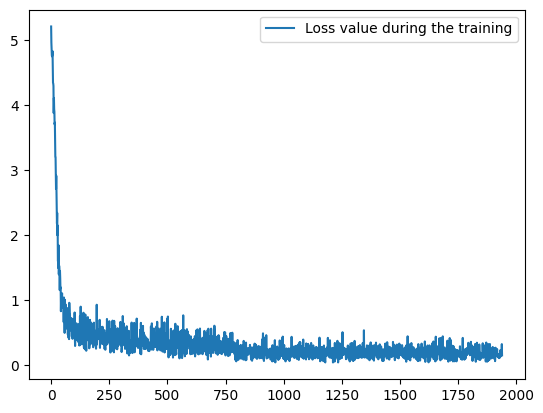

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_history["train_loss"], label="Loss value during the training") 
plt.legend()

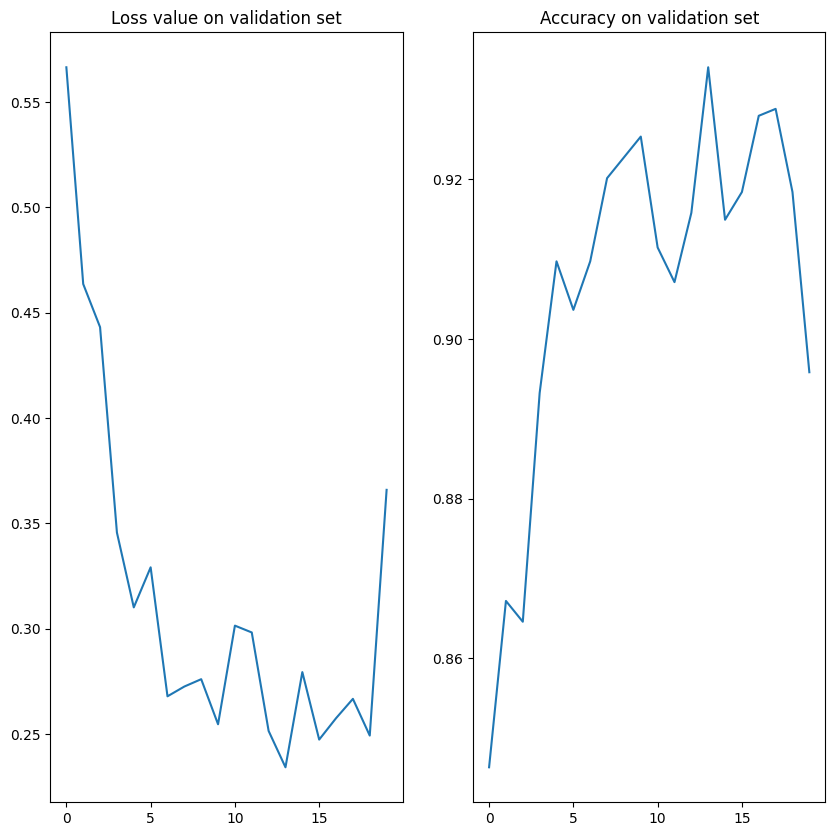

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on validation set")
axs[0].plot(eval_metrics_history["val_loss"])
axs[1].set_title("Accuracy on validation set")
axs[1].plot(eval_metrics_history["val_accuracy"])